# テーマ：Fashion-MNISTデータセットを畳み込みニューラルネットワーク（CNN）で学習する
## 制約
* 全体の実行時間は60分以内

## 今回参考にしたもの
* [Get started with TensorFlow 2.0 for experts](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/quickstart/advanced.ipynb)

## 0. Install TensorFlow 2.0

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 66kB/s 
    100% |████████████████████████████████| 419kB 12.5MB/s 
    100% |████████████████████████████████| 61kB 27.1MB/s 
    100% |████████████████████████████████| 3.0MB 8.8MB/s 


## 1. Prepare dataset

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

#print(tfds.list_builders())
dataset, info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']
print(info)

W0427 03:45:36.632865 139660910581632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:325: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)
    },
    total_num_examples=70000,
    splits={
        'test': <tfds.core.SplitInfo num_examples=10000>,
        'train': <tfds.core.SplitInfo num_examples=60000>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @article{DBLP:journals/corr/abs-1708-07747,
          author    = {Han Xiao and
                   

In [0]:
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 32

dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)

## 2. Data Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator()
datagen = ImageDataGenerator(rotation_range = 10, horizontal_flip = True, zoom_range = 0.1)

## 3. Define model

In [0]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Dropout, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras import Model

class CNNModel(Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        drop_rate = 0.5
        
        self._layers = ([
            Conv2D(32, 3), # 28, 28, 1 -> 26, 26, 32
            BatchNormalization(),
            Activation(tf.nn.relu),
            Conv2D(64, 3), # 26, 26, 32 -> 24, 24, 64
            BatchNormalization(),
            Activation(tf.nn.relu),
            MaxPool2D(), # 24, 24, 64 -> 12, 12, 64
            Conv2D(128, 3), # 12, 12, 64 -> 10, 10, 128
            BatchNormalization(),
            Activation(tf.nn.relu),
            Conv2D(256, 3), # 10, 10, 128 -> 8, 8, 256
            BatchNormalization(),
            Activation(tf.nn.relu),
            MaxPool2D(), # 8, 8, 256 -> 4, 4, 256
            Flatten(), # 4, 4, 256 -> 4096
            Dense(256), # 4096 -> 256
            BatchNormalization(),
            Dropout(drop_rate),
            Activation(tf.nn.relu),
            Dense(10, activation = 'softmax') # 256 -> 10                        
        ])                
        
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x
       
    
model = CNNModel()

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

## 4. Prepare training

In [0]:
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

In [0]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(label, predictions)
        
@tf.function
def test_step(image, label):
    predictions = model(image)
    loss = loss_object(label, predictions)
    
    test_loss(loss)
    test_accuracy(label, predictions)

## 5. Train

In [43]:
import time

num_epoch = 80
start_time = time.time()

#train_accuracies = []
#test_accuracies = []
train_accuracies_with_da = []
test_accuracies_with_da = []


for epoch in range(num_epoch):    
    for image, label in dataset_train:
        for _image, _label in datagen.flow(image, label, batch_size = batch_size):
            train_step(_image, _label)
            break
        
    for test_image, test_label in dataset_test:
        test_step(test_image, test_label)
        
    #train_accuracies.append(train_accuracy.result())
    #test_accuracies.append(test_accuracy.result())
    train_accuracies_with_da.append(train_accuracy.result())
    test_accuracies_with_da.append(test_accuracy.result())
    
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100, spent_time / 60))

Epoch 1, Loss: 0.4946324825286865, Accuracy: 81.711669921875, Test Loss: 0.3264978528022766, Test Accuracy: 87.84000396728516, spent_time: 0.701864755153656 min
Epoch 2, Loss: 0.4105800986289978, Accuracy: 84.80332946777344, Test Loss: 0.3105478882789612, Test Accuracy: 88.58000183105469, spent_time: 1.3360997835795085 min
Epoch 3, Loss: 0.37053966522216797, Accuracy: 86.2477798461914, Test Loss: 0.29877400398254395, Test Accuracy: 89.07333374023438, spent_time: 1.984490974744161 min
Epoch 4, Loss: 0.34314727783203125, Accuracy: 87.3004150390625, Test Loss: 0.29279541969299316, Test Accuracy: 89.40750122070312, spent_time: 2.6201993227005005 min
Epoch 5, Loss: 0.32348930835723877, Accuracy: 88.04133605957031, Test Loss: 0.28621771931648254, Test Accuracy: 89.68599700927734, spent_time: 3.2601821422576904 min
Epoch 6, Loss: 0.3082753121852875, Accuracy: 88.58722686767578, Test Loss: 0.2800993323326111, Test Accuracy: 89.96499633789062, spent_time: 3.903700570265452 min
Epoch 7, Loss: 0.

## 6. Show transition of accuracy

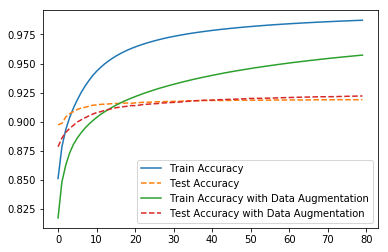

In [44]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, linestyle = 'dashed', label = 'Test Accuracy')
plt.plot(train_accuracies_with_da, label = 'Train Accuracy with Data Augmentation')
plt.plot(test_accuracies_with_da, linestyle = 'dashed', label = 'Test Accuracy with Data Augmentation')
plt.legend()
plt.show()